# VAE

- 元論文 Auto-Encoding Variational Bayes https://arxiv.org/abs/1312.6114 (2013)

AutoEncoderの構造にEncoderとDecoderの中間での出力を特定の確率分布に近似させるのが**VAE(Variational Auto Encoder)**。

雑に言っちゃえばこんな感じ。この中間のパラメータを **潜在変数** と呼んだりする。 

```bash
Input X -> Encoder -> p(z|x) -> Decoder X
```
<img src='assets/vae.png' width=400>

VAEでは確率分布（黄色）を平均μ, 標準偏差σのガウス分布で近似する。つまり、Encoderでは最後にMLPを２つ用意し、それぞれの出力をμとσとして扱う。Decoderの入力にはN(μ, σ)からサンプリングしたノイズzをMLPでデコードする。

```bash
Input X -> Encoder ->  mu    ->   z ~N(mu, sigma) -> Decoder -> X
                         |-----> sigma  -----------------^
```
<img src='assets/vae_3.png' width=400>

だけど、ガウス分布からサンプリングするネットワークを組むと、学習（誤差の逆伝搬）ができなくなる。そこで、Parameterization Trickという方法を使う。Parameterization Trickでは、サンプリングする代わりに、μとσから直接的にzを求める。zは次式で計算される。

εは平均0、標準偏差1のガウス分布からサンプリングするものだけど、Encoderへの逆伝搬には影響しない。

$
z = \mu + \epsilon e^{0.5 + \sigma}, \epsilon \sim N(0, 1)
$

つまり、 VAEの全体的な構造はこうなる。ここでは潜在変数を２次元にしている。（MNISTでは２次元でなんとかなるが、Cifar10のように画像の分散が大きくなると、潜在変数も大きくする必要がある）

```bash
Input (784) -> Linear (256) -> Linear(2) -> Linear(2) -> Linear(256) -> Output(784)
                             |-------------> Linear(2)  --------^

```

<img src='assets/vae_2.png' width=400>

VAE の Loss は *Reconstruction Loss* と *KLDivergence* の２つの Multi task loss になる。 LreconstructionはAutoEncoderのロス（画像を復元するための入力画像と出力画像のCrossEntropy)。KLDは潜在変数をある特定の値に近づけるために導入されている。

ここでは潜在変数となるμ、σをそれぞれ0,1に近づけるために次式で定義される。

$ Loss = L_{Reconstruction} + D_{KL}$

$D_{KL} = - \frac{1}{2}(1 + \sigma - \mu^2 - e^{\sigma})$


## Import and Config

In [108]:
import torch
import torch.nn.functional as F
import torchvision
import numpy as np
from collections import OrderedDict
from easydict import EasyDict
import argparse
import os
import matplotlib.pyplot as plt
import pandas as pd
from torchsummary import summary
from _main_base import *

#---
# config
#---
cfg = EasyDict()

# class
cfg.CLASS_LABEL = ['akahara', 'madara'] # list, dict('label' : '[B, G, R]')
cfg.CLASS_NUM = 10

# model
cfg.INPUT_HEIGHT = 28
cfg.INPUT_WIDTH = 28
cfg.INPUT_CHANNEL = 1
cfg.INPUT_MODE = None # None, RGB, GRAY, EDGE, CLASS_LABEL

cfg.OUTPUT_HEIGHT = 28
cfg.OUTPUT_WIDTH = 28
cfg.OUTPUT_CHANNEL = 1
cfg.OUTPUT_MODE = None  # RGB, GRAY, EDGE, CLASS_LABEL

cfg.OUTPUT_CMAP = 'gray' # matplotlib cmap  (default : None)

# AE config
cfg.VAE_Z_DIM = 2
cfg.AE_DIM = 32 # AE encodes feature to this
cfg.AE_STACK_NUM = 2 # AE stack number, e.g. Input > encoder 1 > encoder 2 > ... > encoder this
cfg.AE_DIM_EXPAND_BASE = 2 # AE : layer output = AE_DIM * (AE_DIM_EXPAND_BASE ** N (encoder or decoder stage))
cfg.VAE_KLD_BALANCE = 1 # loss = lossReconstruction + this * loss_KLD

cfg.CHANNEL_AXIS = 1 # 1 ... [mb, c, h, w], 3 ... [mb, h, w, c]

cfg.GPU = False
cfg.DEVICE = torch.device('cuda' if cfg.GPU and torch.cuda.is_available() else 'cpu')

# train
cfg.TRAIN = EasyDict()

cfg.PREFIX = 'VAE_mnist'
cfg.TRAIN.MODEL_E_SAVE_PATH = 'models/' + cfg.PREFIX + '_E_{}.pt' # save model to this path
cfg.TRAIN.MODEL_D_SAVE_PATH = 'models/' + cfg.PREFIX + '_D_{}.pt' # save model to this path
cfg.TRAIN.MODEL_SAVE_INTERVAL = 10_000 # save model in each this
cfg.TRAIN.ITERATION = 30_000 # max training iteration
cfg.TRAIN.MINIBATCH = 512
cfg.TRAIN.OPTIMIZER = torch.optim.Adam
cfg.TRAIN.LEARNING_PARAMS = {'lr' : 0.001, 'weight_decay' : 1e-5}
cfg.TRAIN.LOSS_FUNCTION = torch.nn.MSELoss(reduction='sum')

cfg.TRAIN.DATA_PATH = './data/' # use this dataset path
cfg.TRAIN.DATA_HORIZONTAL_FLIP = False # data augmentation : holizontal flip
cfg.TRAIN.DATA_VERTICAL_FLIP = False # data augmentation : vertical flip
cfg.TRAIN.DATA_ROTATION = False # data augmentation : rotation False, or integer

cfg.TRAIN.DISPLAY_ITERATION_INTERVAL = 1000
cfg.TRAIN.LEARNING_PROCESS_PROGRESS_INTERVAL = 10 # save loss in each this
cfg.TRAIN.LEARNING_PROCESS_RESULT_SHOW = 1000 # integer , False (not show)
cfg.TRAIN.LEARNING_PROCESS_RESULT_SAVE = True # save result image and loss text
cfg.TRAIN.LEARNING_PROCESS_RESULT_INTERVAL = 10_000 # save image and loss text in each this
cfg.TRAIN.LEARNING_PROCESS_RESULT_IMAGE_PATH = 'result/' + cfg.PREFIX + '_result_{}.jpg'
cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH = 'result/' + cfg.PREFIX + '_loss.txt'


# test
cfg.TEST = EasyDict()
cfg.TEST.MODEL_E_PATH = cfg.TRAIN.MODEL_E_SAVE_PATH.format('final') # use this trained path
cfg.TEST.MODEL_D_PATH = cfg.TRAIN.MODEL_D_SAVE_PATH.format('final') # use this trained path
cfg.TEST.DATA_PATH = './data' # use this dataset path
cfg.TEST.MINIBATCH = 10
cfg.TEST.MAX_SAMPLES = 30
cfg.TEST.ITERATION = 2
cfg.TEST.RESULT_SAVE = False
cfg.TEST.RESULT_IMAGE_PATH = 'result/' + cfg.PREFIX + '_result_{}.jpg'

# random seed
torch.manual_seed(0)


# make model save directory
def make_dir(path):
    if '/' in path:
        model_save_dir = '/'.join(path.split('/')[:-1])
        os.makedirs(model_save_dir, exist_ok=True)

make_dir(cfg.TRAIN.MODEL_E_SAVE_PATH)
make_dir(cfg.TRAIN.MODEL_D_SAVE_PATH)
make_dir(cfg.TRAIN.LEARNING_PROCESS_RESULT_IMAGE_PATH)
make_dir(cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH)


## Define Model

In [104]:
class Flatten(torch.nn.Module):
    def forward(self, x):
        x = x.view(x.size()[0], -1)
        return x

class VAE_Encoder(torch.nn.Module):
    def __init__(self):
        super(VAE_Encoder, self).__init__()
        _layer_dim = max(cfg.AE_DIM * (cfg.AE_DIM_EXPAND_BASE ** (cfg.AE_STACK_NUM - 1)), cfg.AE_DIM)
        
        # Encoder
        module = OrderedDict({
            'encoder_flatten' : Flatten(),
            'encoder_1_layer' : torch.nn.Linear(cfg.INPUT_HEIGHT * cfg.INPUT_WIDTH * cfg.INPUT_CHANNEL, _layer_dim),
            'encoder_1_activation' : torch.nn.ReLU()
        })
        
        for i in range(2, cfg.AE_STACK_NUM + 1):
            module['encoder_{}_layer'.format(i)] = torch.nn.Linear(_layer_dim, _layer_dim // cfg.AE_DIM_EXPAND_BASE)
            module['encoder_{}_activation'.format(i)] = torch.nn.ReLU()      
            _layer_dim //= cfg.AE_DIM_EXPAND_BASE
            
        self.module = torch.nn.Sequential(module)
            
        self.encoder_mu = torch.nn.Linear(_layer_dim, cfg.VAE_Z_DIM)
        self.encoder_sigma = torch.nn.Linear(_layer_dim, cfg.VAE_Z_DIM)
        
    def forward(self, x):
        x = self.module(x)
        mu = self.encoder_mu(x)
        sigma = self.encoder_sigma(x)
        return mu, sigma
    
    
class VAE_Sampler(torch.nn.Module):
    def __init__(self):
        super(VAE_Sampler, self).__init__()
        
    def forward(self, x):
        mu, sigma = x
        mb, _ = mu.size()
        epsilon = torch.tensor(np.random.normal(0, 1, [mb, cfg.VAE_Z_DIM]), dtype=torch.float32).to(cfg.DEVICE)
        std = torch.exp(0.5 * sigma)
        sample_z = mu + epsilon * std
        return sample_z
    
    
class VAE_Decoder(torch.nn.Module):
    def __init__(self):
        super(VAE_Decoder, self).__init__()
        _layer_dim = cfg.AE_DIM
        
        module = OrderedDict({
            'decoder_input' : torch.nn.Linear(cfg.VAE_Z_DIM, _layer_dim),
            'decoder_input_activation' : torch.nn.ReLU()
        })

        for i in range(cfg.AE_STACK_NUM, 1, -1):
            module['decoder_{}_layer'.format(i)] = torch.nn.Linear(_layer_dim, _layer_dim * cfg.AE_DIM_EXPAND_BASE)
            module['decoder_{}_activation'.format(i)] = torch.nn.ReLU()
            _layer_dim *= cfg.AE_DIM_EXPAND_BASE
            
        module['decoder_1'] = torch.nn.Linear(_layer_dim, cfg.OUTPUT_HEIGHT * cfg.OUTPUT_WIDTH * cfg.OUTPUT_CHANNEL)
        module['decoder_out_activation'] = torch.nn.Tanh()

        self.module = torch.nn.Sequential(module)
        
        
    def forward(self, x):
        x = self.module(x)
        return x

def loss_KLDivergence(mu, sigma):
    return - 0.5 * torch.sum(1 + sigma - torch.pow(mu, 2) - torch.exp(sigma))


## Utility

In [105]:
def result_show(model, Xs, path=None, save=False, show=False, figsize=(12, 4), cmap=None):
    _Xs = Xs.detach().cpu().numpy()
    _Xs = (_Xs * 127.5 + 127.5).astype(np.uint8)
    
    ys = model(Xs).detach().cpu().numpy()
    ys = (ys * 127.5 + 127.5).astype(np.uint8)
    ys = ys.reshape([-1, cfg.OUTPUT_CHANNEL, cfg.OUTPUT_HEIGHT, cfg.OUTPUT_WIDTH])
    
    if cfg.OUTPUT_CHANNEL == 1:
        _Xs = _Xs[:, 0]
        ys = ys[:, 0]
    else:
        _Xs = _Xs.transpose(0, 2, 3, 1)
        ys = ys.transpose(0, 2, 3, 1)

    show_max = min(cfg.TEST.MINIBATCH, len(ys))
        
    plt.figure(figsize=figsize)
    for i in range(show_max):
        # show input
        _X = _Xs[i]
        plt.subplot(2, show_max, i + 1)
        plt.imshow(_X, cmap=cmap)
        plt.axis('off')
        plt.title('Input{}'.format(i + 1))
        
        # show output
        _y = ys[i]
        plt.subplot(2, show_max, i + 1 + show_max)
        plt.imshow(_y, cmap=cmap)
        plt.axis('off')
        plt.title('Output{}'.format(i + 1))

    plt.tight_layout()
    
    if save:
        plt.savefig(path)
        print('result was saved to >> {}'.format(path))

    if show:
        plt.show()
    else:
        plt.close()

## Train

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                   [-1, 64]          50,240
              ReLU-3                   [-1, 64]               0
            Linear-4                   [-1, 32]           2,080
              ReLU-5                   [-1, 32]               0
            Linear-6                    [-1, 2]              66
            Linear-7                    [-1, 2]              66
Total params: 52,452
Trainable params: 52,452
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.20
Estimated Total Size (MB): 0.21
----------------------------------------------------------------
----------------------------------------------------------------
        Layer (type)               Output S

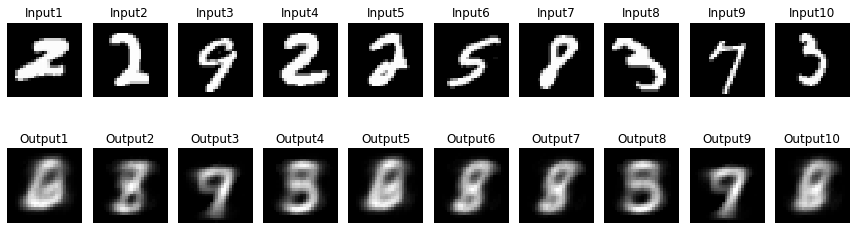

Iter:2000, Loss:77267.5000 (Recon:74409.9766, KLD:2857.5271)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

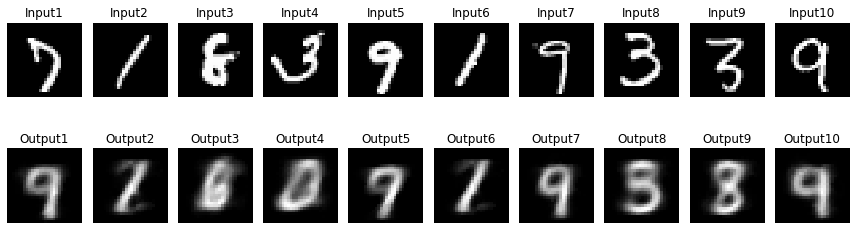

Iter:3000, Loss:72496.4375 (Recon:69488.1953, KLD:3008.2446)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

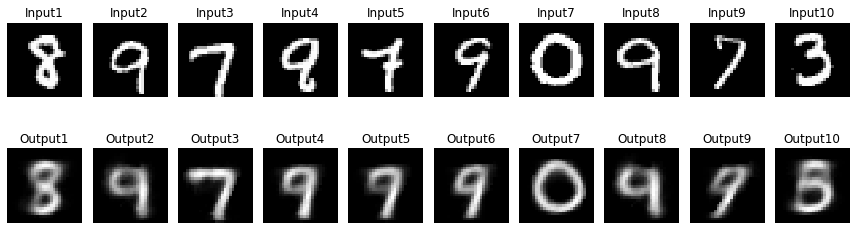

Iter:4000, Loss:71160.3828 (Recon:68036.3359, KLD:3124.0442)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

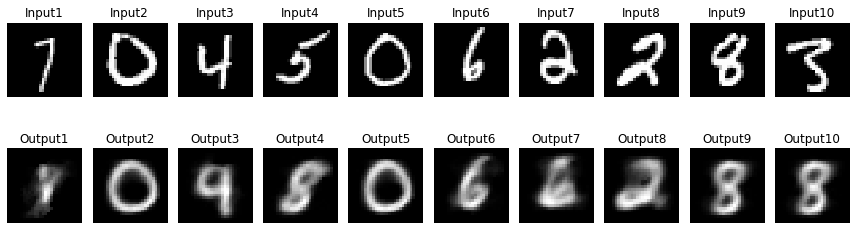

Iter:5000, Loss:70985.2969 (Recon:67770.7812, KLD:3214.5156)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

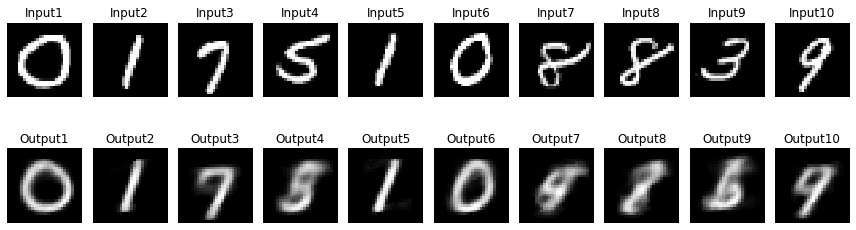

Iter:6000, Loss:71125.7969 (Recon:68004.9766, KLD:3120.8208)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

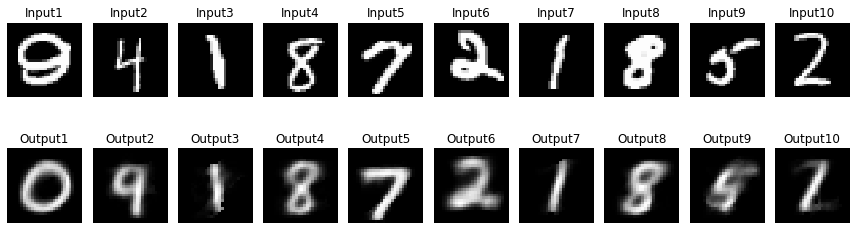

Iter:7000, Loss:68732.8828 (Recon:65447.2734, KLD:3285.6064)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

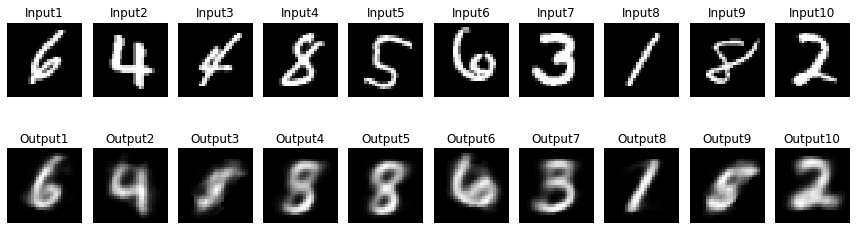

Iter:8000, Loss:68880.4297 (Recon:65697.3750, KLD:3183.0518)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

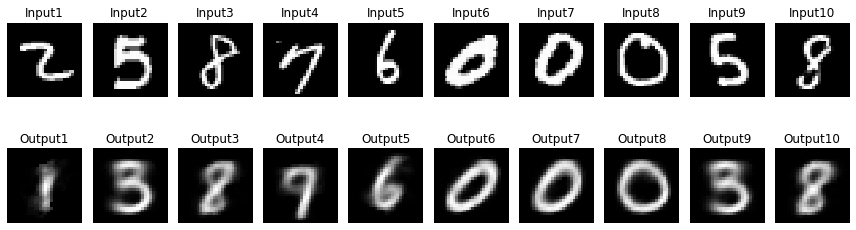

Iter:9000, Loss:69550.6328 (Recon:66231.6562, KLD:3318.9749)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

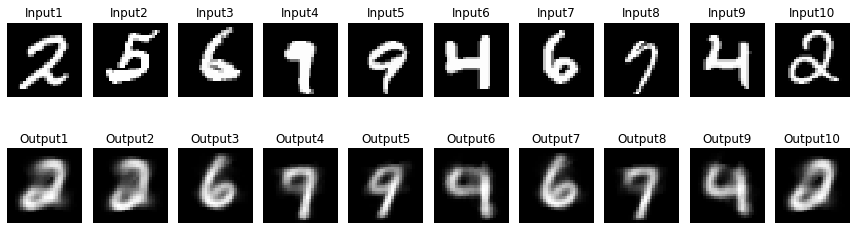

Iter:10000, Loss:69657.2578 (Recon:66346.4766, KLD:3310.7803)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

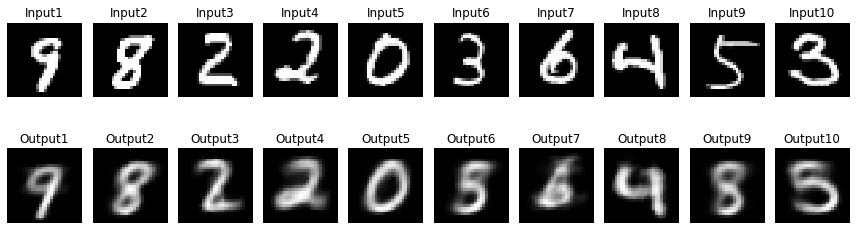

result was saved to >> result/VAE_mnist_result_iter10000.jpg
Iter:11000, Loss:69192.9922 (Recon:65860.9688, KLD:3332.0242)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

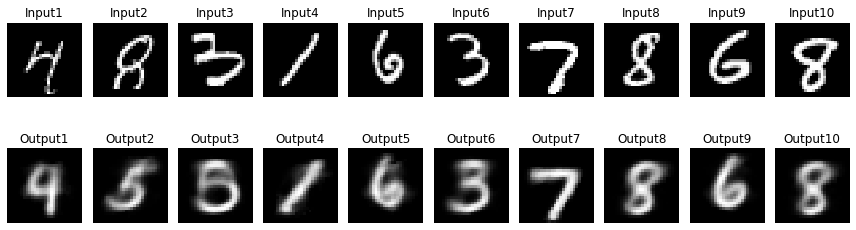

Iter:12000, Loss:67651.0469 (Recon:64353.4883, KLD:3297.5601)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

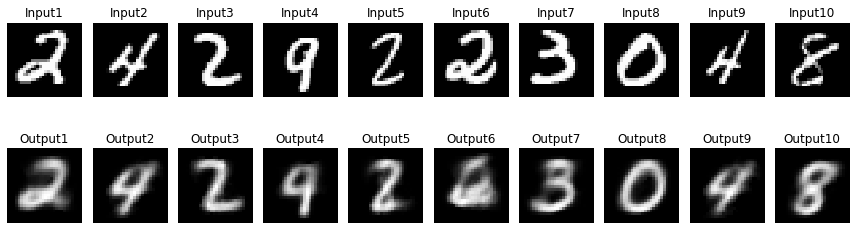

Iter:13000, Loss:68291.6562 (Recon:64920.1328, KLD:3371.5200)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

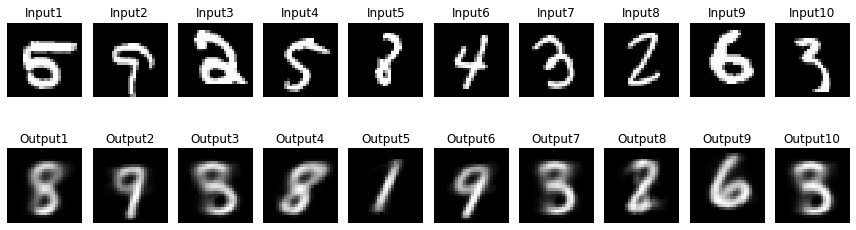

Iter:14000, Loss:66660.6797 (Recon:63349.4688, KLD:3311.2112)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

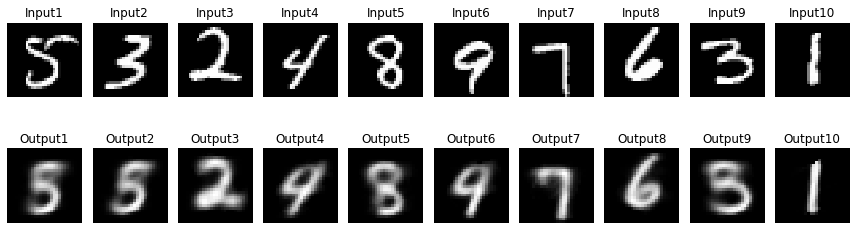

Iter:15000, Loss:67031.7656 (Recon:63637.3516, KLD:3394.4116)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

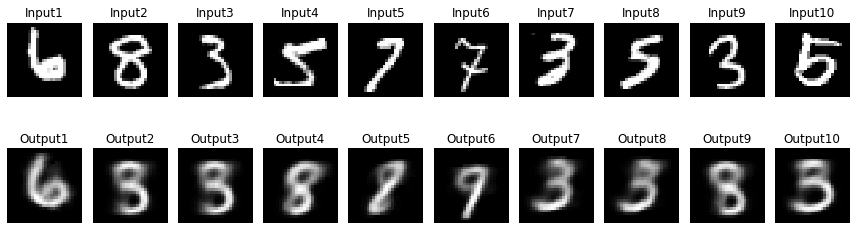

Iter:16000, Loss:66549.2344 (Recon:63166.5664, KLD:3382.6697)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

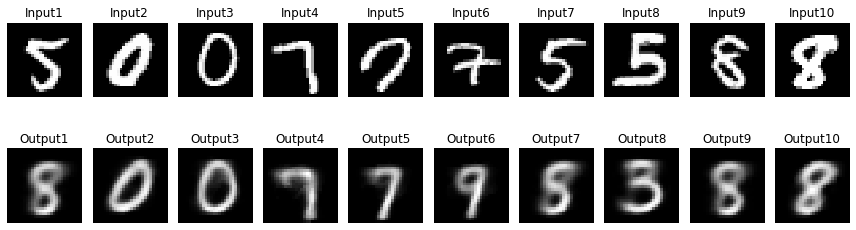

Iter:17000, Loss:65915.1797 (Recon:62525.2930, KLD:3389.8850)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

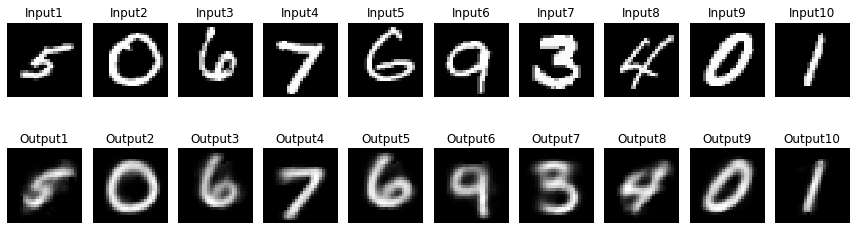

Iter:18000, Loss:66983.1328 (Recon:63571.3633, KLD:3411.7729)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

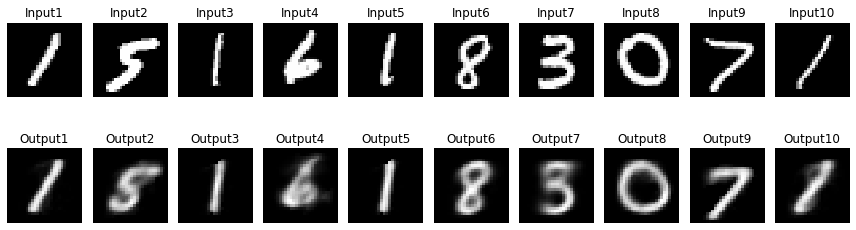

Iter:19000, Loss:66454.9297 (Recon:63019.5234, KLD:3435.4038)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

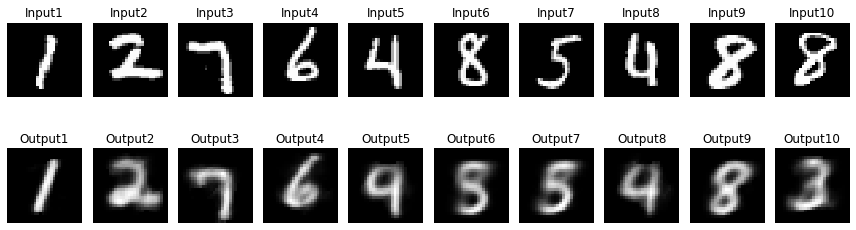

Iter:20000, Loss:66144.6406 (Recon:62754.3008, KLD:3390.3369)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

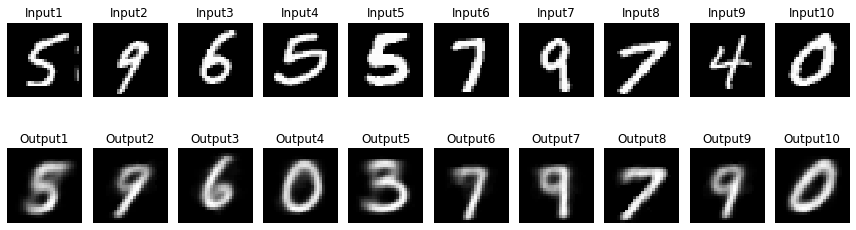

result was saved to >> result/VAE_mnist_result_iter20000.jpg
Iter:21000, Loss:63021.1289 (Recon:59578.7695, KLD:3442.3584)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

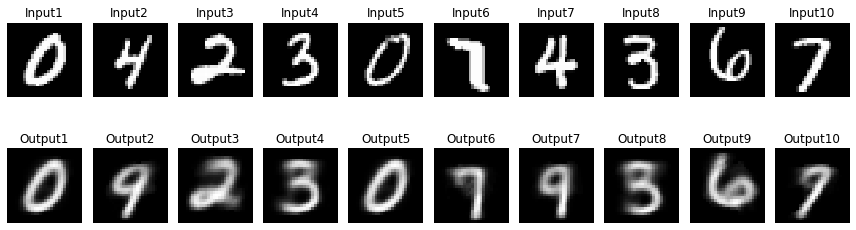

Iter:22000, Loss:65442.9922 (Recon:61990.9844, KLD:3452.0068)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

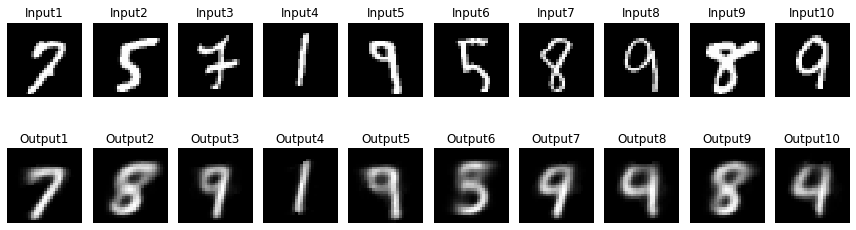

Iter:23000, Loss:66261.1328 (Recon:62824.8320, KLD:3436.3044)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

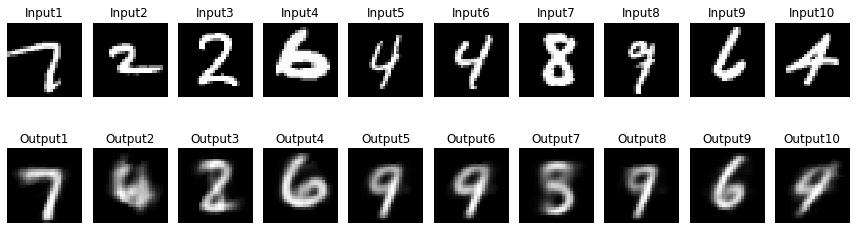

Iter:24000, Loss:64589.0391 (Recon:61077.7109, KLD:3511.3276)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

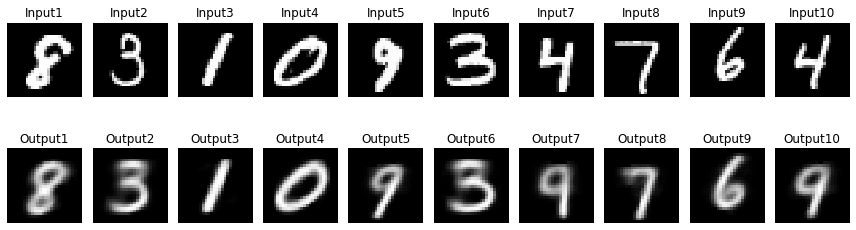

Iter:25000, Loss:65693.6094 (Recon:62223.4727, KLD:3470.1340)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

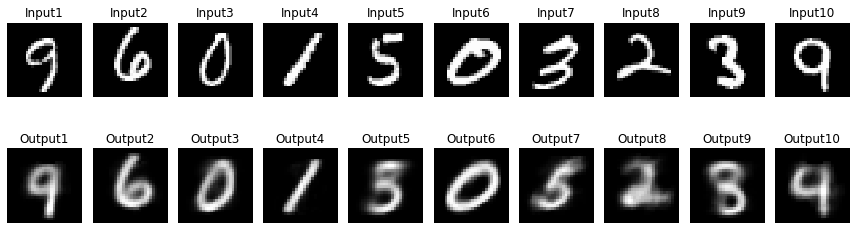

Iter:26000, Loss:62994.4883 (Recon:59503.4023, KLD:3491.0859)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

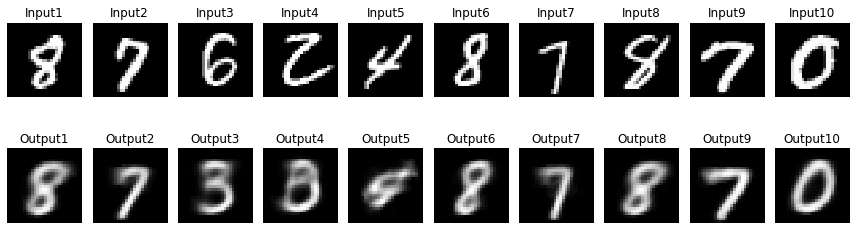

Iter:27000, Loss:65872.6016 (Recon:62387.6523, KLD:3484.9475)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

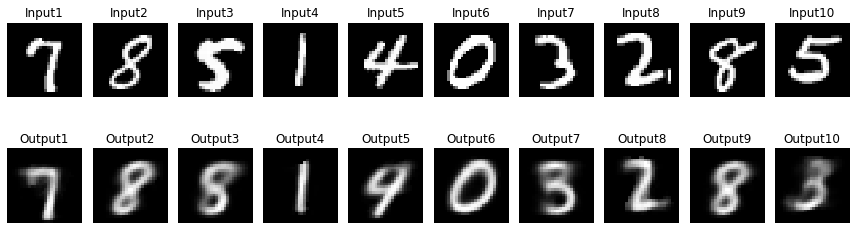

Iter:28000, Loss:64124.0391 (Recon:60588.2656, KLD:3535.7747)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

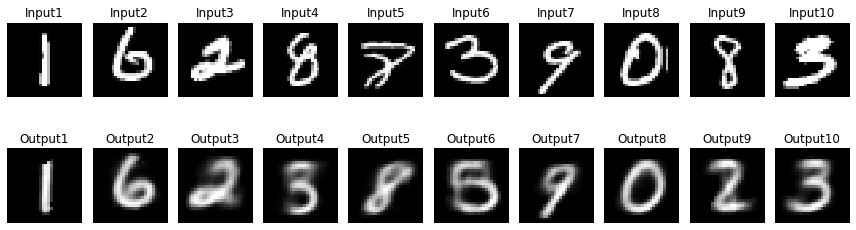

Iter:29000, Loss:65173.3125 (Recon:61604.3750, KLD:3568.9377)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

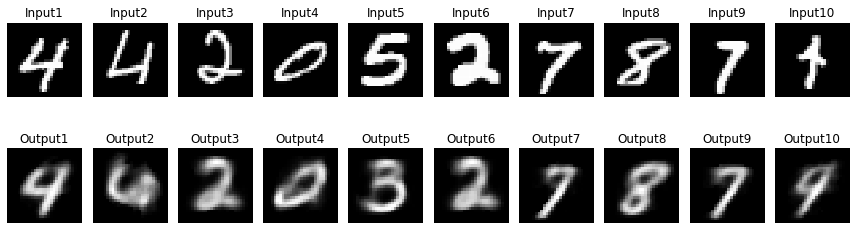

Iter:30000, Loss:65464.0000 (Recon:61856.7305, KLD:3607.2700)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

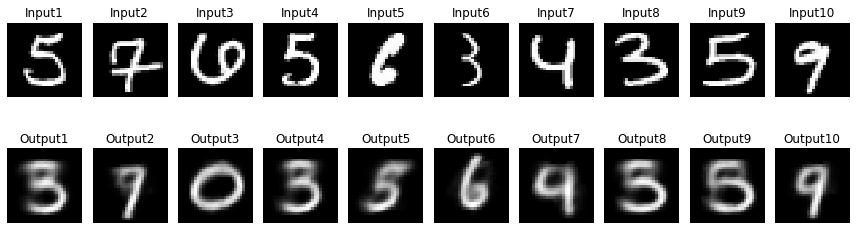

result was saved to >> result/VAE_mnist_result_iter30000.jpg
final paramters were saved toE >> models/VAE_mnist_E_final.pt, D >> models/VAE_mnist_D_final.pt
loss was saved to >> result/VAE_mnist_loss.txt


In [106]:
# train
def train():
    # model
    model_encoder = VAE_Encoder().to(cfg.DEVICE)
    model_sampler = VAE_Sampler().to(cfg.DEVICE)
    model_decoder = VAE_Decoder().to(cfg.DEVICE)
    model = torch.nn.Sequential(model_encoder, model_sampler, model_decoder)
    
    summary(model_encoder, (cfg.INPUT_CHANNEL, cfg.INPUT_HEIGHT, cfg.INPUT_WIDTH))
    summary(model_decoder, (cfg.VAE_Z_DIM, ))
    
    opt = cfg.TRAIN.OPTIMIZER(model.parameters(), **cfg.TRAIN.LEARNING_PARAMS)
    
    #path_dict = data_load(cfg)
    #paths = path_dict['paths']
    #paths_gt = path_dict['paths_gt']

    trainset = torchvision.datasets.MNIST(root=cfg.TRAIN.DATA_PATH , train=True, download=True, transform=None)
    train_Xs = trainset.data.numpy()
    train_ts = trainset.targets
    
    print('training data : ', train_Xs.shape)

    # training
    mbi = 0
    train_N = len(train_Xs)
    train_ind = np.arange(train_N)
    np.random.seed(0)
    np.random.shuffle(train_ind)

    list_iter = []
    list_loss = []
    list_loss_RECONSTRUCTION = []
    list_loss_KLD = []

    print('training start')
    progres_bar = ''
    
    for i in range(cfg.TRAIN.ITERATION):
        # get minibatch
        if mbi + cfg.TRAIN.MINIBATCH > train_N:
            mb_ind = train_ind[mbi:]
            np.random.shuffle(train_ind)
            mb_ind = np.hstack((mb_ind, train_ind[ : (cfg.TRAIN.MINIBATCH - (train_N - mbi))]))
            mbi = cfg.TRAIN.MINIBATCH - (train_N - mbi)
        else:
            mb_ind = train_ind[mbi : mbi + cfg.TRAIN.MINIBATCH]
            mbi += cfg.TRAIN.MINIBATCH

        # train
        opt.zero_grad()

        # sample X, y
        Xs = torch.tensor(preprocess(train_Xs[mb_ind], cfg, cfg.INPUT_MODE, 
                                    hf=cfg.TRAIN.DATA_HORIZONTAL_FLIP, vf=cfg.TRAIN.DATA_VERTICAL_FLIP, rot=cfg.TRAIN.DATA_ROTATION),
                          dtype=torch.float).to(cfg.DEVICE)
        #ts = torch.tensor(train_ts[mb_ind], dtype=torch.float).to(device)

        # forward
        mu, sigma = model_encoder(Xs)
        z = model_sampler([mu, sigma])
        ys = model_decoder(z)
        
        # loss
        loss_recon = cfg.TRAIN.LOSS_FUNCTION(ys, Xs.view(cfg.TRAIN.MINIBATCH, -1))
        
        # loss KLDivergence
        loss_kld = loss_KLDivergence(mu, sigma)
        loss = loss_recon + cfg.VAE_KLD_BALANCE * loss_kld

        # update
        loss.backward()
        opt.step()

        progres_bar += '|'
        print('\r' + progres_bar, end='')

        _loss = loss.item()
        _loss_recon = loss_recon.item()
        _loss_kld = loss_kld.item()

        if (i + 1) % cfg.TRAIN.LEARNING_PROCESS_PROGRESS_INTERVAL == 0:
            progres_bar += str(i + 1)
            print('\r' + progres_bar, end='')

            # save process result
            if cfg.TRAIN.LEARNING_PROCESS_RESULT_SAVE:
                list_iter.append(i + 1)
                list_loss.append(_loss)
                list_loss_RECONSTRUCTION.append(_loss_recon)
                list_loss_KLD.append(_loss_kld)
    
        # display training state
        if (i + 1) % cfg.TRAIN.DISPLAY_ITERATION_INTERVAL == 0:
            print('\r' + ' ' * len(progres_bar), end='')
            print('\rIter:{}, Loss:{:.4f} (Recon:{:.4f}, KLD:{:.4f})'.format(i + 1, _loss, _loss_recon, _loss_kld))
            progres_bar = ''

        # save parameters
        if (cfg.TRAIN.MODEL_SAVE_INTERVAL != False) and ((i + 1) % cfg.TRAIN.MODEL_SAVE_INTERVAL == 0):
            save_path_E = cfg.TRAIN.MODEL_E_SAVE_PATH.format('iter{}'.format(i + 1))
            save_path_D = cfg.TRAIN.MODEL_D_SAVE_PATH.format('iter{}'.format(i + 1))
            torch.save(model_encoder.state_dict(), save_path_E)
            torch.save(model_decoder.state_dict(), save_path_D)
            print('save E >> {}, D >> {}'.format(save_path_E, save_path_D))

        # show process result
        if (cfg.TRAIN.LEARNING_PROCESS_RESULT_SHOW != False) and ((i + 1) % cfg.TRAIN.LEARNING_PROCESS_RESULT_SHOW == 0):
            result_show(
                model, Xs, cfg.TRAIN.LEARNING_PROCESS_RESULT_IMAGE_PATH.format('iter' + str(i + 1)), 
                save=False, show=True, cmap=cfg.OUTPUT_CMAP)
            
        # save process result
        if cfg.TRAIN.LEARNING_PROCESS_RESULT_SAVE and ((i + 1) % cfg.TRAIN.LEARNING_PROCESS_RESULT_INTERVAL == 0):
            result_show(
                model, Xs, cfg.TRAIN.LEARNING_PROCESS_RESULT_IMAGE_PATH.format('iter' + str(i + 1)), 
                save=True, show=False, cmap=cfg.OUTPUT_CMAP)

    save_path_E = cfg.TRAIN.MODEL_E_SAVE_PATH.format('final')
    save_path_D = cfg.TRAIN.MODEL_D_SAVE_PATH.format('final')
    torch.save(model_encoder.state_dict(), save_path_E)
    torch.save(model_decoder.state_dict(), save_path_D)
    print('final paramters were saved toE >> {}, D >> {}'.format(save_path_E, save_path_D))

    if cfg.TRAIN.LEARNING_PROCESS_RESULT_SAVE:
        f = open(cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH, 'w')
        df = pd.DataFrame({'iteration' : list_iter, 'loss' : list_loss, 'loss_reconstruction' : list_loss_RECONSTRUCTION, 
                           'loss_KLD' : list_loss_KLD})
        df.to_csv(cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH, index=False)
        print('loss was saved to >> {}'.format(cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH))

train()

## Test

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                   [-1, 64]          50,240
              ReLU-3                   [-1, 64]               0
            Linear-4                   [-1, 32]           2,080
              ReLU-5                   [-1, 32]               0
            Linear-6                    [-1, 2]              66
            Linear-7                    [-1, 2]              66
Total params: 52,452
Trainable params: 52,452
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.20
Estimated Total Size (MB): 0.21
----------------------------------------------------------------
----------------------------------------------------------------
        Layer (type)               Output S

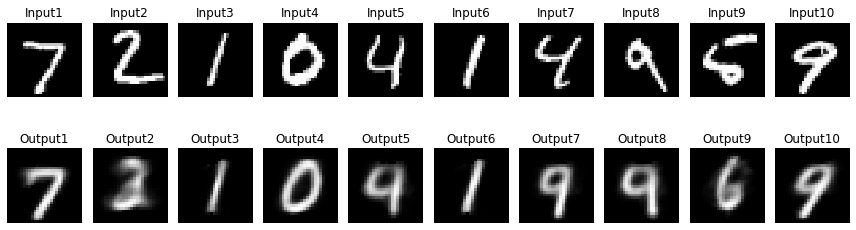

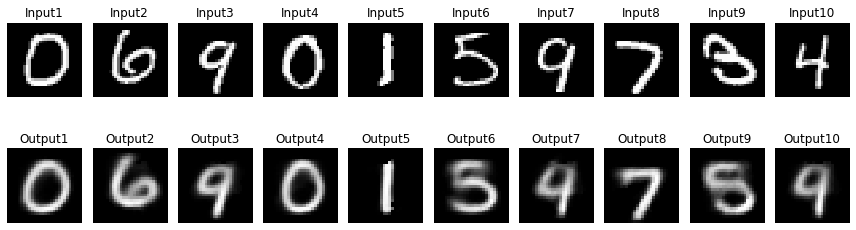

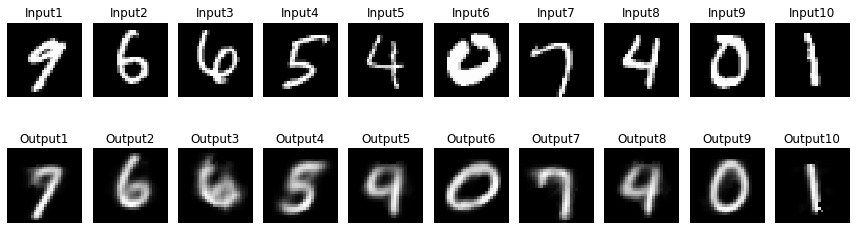

In [109]:
# test
def test():
    #print('-' * 20　+ '\ntest function\n' + '-' * 20)
    
    model_encoder = VAE_Encoder().to(cfg.DEVICE)
    model_sampler = VAE_Sampler().to(cfg.DEVICE)
    model_decoder = VAE_Decoder().to(cfg.DEVICE)
    model = torch.nn.Sequential(model_encoder, model_sampler, model_decoder)
    
    model_encoder.load_state_dict(torch.load(cfg.TEST.MODEL_E_PATH, map_location=torch.device(cfg.DEVICE)))
    model_decoder.load_state_dict(torch.load(cfg.TEST.MODEL_D_PATH, map_location=torch.device(cfg.DEVICE)))
    model.eval()
    
    summary(model_encoder, (cfg.INPUT_CHANNEL, cfg.INPUT_HEIGHT, cfg.INPUT_WIDTH))
    summary(model_decoder, (cfg.VAE_Z_DIM, ))

    #path_dict = data_load(cfg, train=False, hf=False, vf=False, rot=False)
    #paths = path_dict['paths']
    #paths_gt = path_dict['paths_gt']
    
    trainset = torchvision.datasets.MNIST(root=cfg.TRAIN.DATA_PATH , train=False, download=True, transform=None)
    train_Xs = trainset.data.numpy()
    train_ts = trainset.targets
    
    Test_Num = min(len(train_Xs), cfg.TEST.MAX_SAMPLES)
    
    np.random.seed(0)
    
    with torch.no_grad():
        for i in range(0, Test_Num, cfg.TEST.MINIBATCH):
            mb_ind = np.arange(i, min(i + cfg.TEST.MINIBATCH, Test_Num))
            
            # sample X, y
            Xs = torch.tensor(preprocess(train_Xs[mb_ind], cfg, cfg.INPUT_MODE, hf=False, vf=False, rot=False), dtype=torch.float).to(cfg.DEVICE)           

            result_show(model, Xs, cfg.TEST.RESULT_IMAGE_PATH.format(i + 1), 
                        save=cfg.TEST.RESULT_SAVE, show=True, cmap=cfg.OUTPUT_CMAP)

test()

## Latent Space

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                   [-1, 64]          50,240
              ReLU-3                   [-1, 64]               0
            Linear-4                   [-1, 32]           2,080
              ReLU-5                   [-1, 32]               0
            Linear-6                    [-1, 2]              66
            Linear-7                    [-1, 2]              66
Total params: 52,452
Trainable params: 52,452
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.20
Estimated Total Size (MB): 0.21
----------------------------------------------------------------
----------------------------------------------------------------
        Layer (type)               Output S

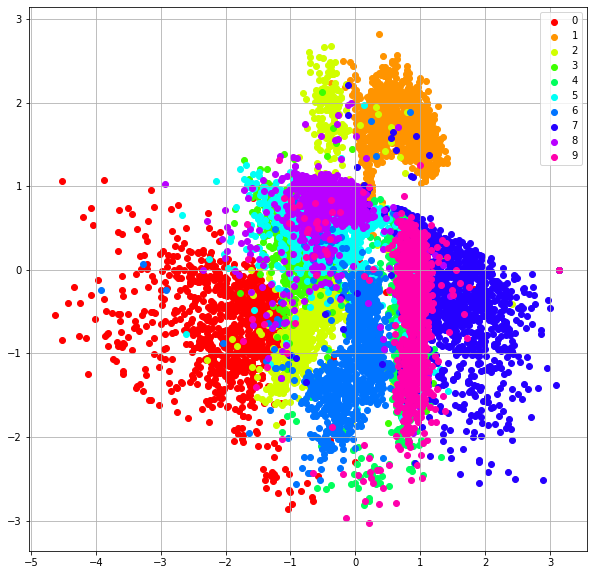

In [110]:
import matplotlib.cm

def latent_show():
    model_encoder = VAE_Encoder().to(cfg.DEVICE)
    model_sampler = VAE_Sampler().to(cfg.DEVICE)
    model_decoder = VAE_Decoder().to(cfg.DEVICE)

    model_encoder.load_state_dict(torch.load(cfg.TEST.MODEL_E_PATH, map_location=torch.device(cfg.DEVICE)))
    model_decoder.load_state_dict(torch.load(cfg.TEST.MODEL_D_PATH, map_location=torch.device(cfg.DEVICE)))
    model_encoder.eval()
    model_sampler.eval()
    model_decoder.eval()
    
    summary(model_encoder, (cfg.INPUT_CHANNEL, cfg.INPUT_HEIGHT, cfg.INPUT_WIDTH))
    summary(model_decoder, (cfg.VAE_Z_DIM, ))

    plt.figure(figsize=[10, 10])
    
    colors = np.array([matplotlib.cm.hsv(i / cfg.CLASS_NUM) for i in range(cfg.CLASS_NUM)])
    
    mb = 512
    
    testset = torchvision.datasets.MNIST(root=cfg.TRAIN.DATA_PATH , train=False, download=True, transform=None)
    test_Xs = testset.data.numpy()
    test_ts = testset.targets
    
    Test_Num = len(test_Xs)
    
    np.random.seed(0)
    
    with torch.no_grad():
        for class_i in range(cfg.CLASS_NUM):
            _test_Xs = test_Xs[test_ts == class_i]

            Test_Num = len(_test_Xs)
            
            z1 = np.ndarray(shape=1)
            z2 = np.ndarray(shape=1)
            
            for i in range(0, Test_Num, mb):
                mb_ind = np.arange(i, min(i + mb, Test_Num))

                # sample X, y
                Xs = torch.tensor(preprocess(_test_Xs[mb_ind], cfg, cfg.INPUT_MODE, hf=False, vf=False, rot=False), dtype=torch.float).to(cfg.DEVICE)           

                # forward
                mu, sigma = model_encoder(Xs)
                z = model_sampler([mu, sigma])
                
                z1 = np.append(z1, z[:, 0])
                z2 = np.append(z2, z[:, 1])

            plt.scatter(z1, z2, c=[colors[class_i]], label=class_i)
    
    plt.grid()
    plt.legend()
    plt.savefig('result/vae_latent_show.png')
    plt.show()
    
latent_show()

## Latent control

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                   [-1, 64]          50,240
              ReLU-3                   [-1, 64]               0
            Linear-4                   [-1, 32]           2,080
              ReLU-5                   [-1, 32]               0
            Linear-6                    [-1, 2]              66
            Linear-7                    [-1, 2]              66
Total params: 52,452
Trainable params: 52,452
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.20
Estimated Total Size (MB): 0.21
----------------------------------------------------------------
----------------------------------------------------------------
        Layer (type)               Output S

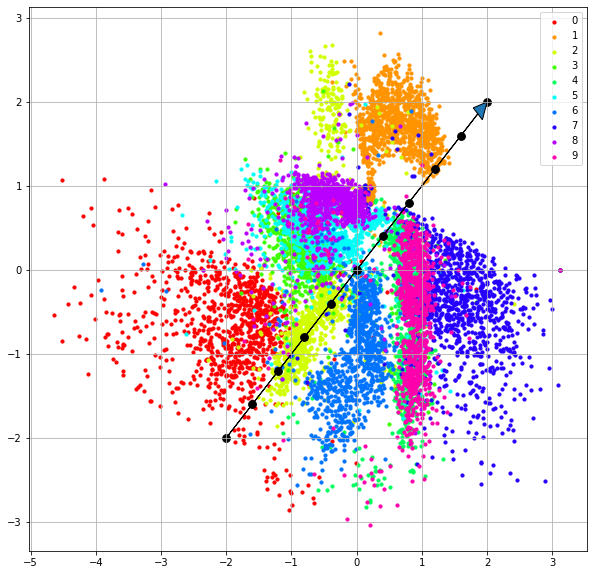

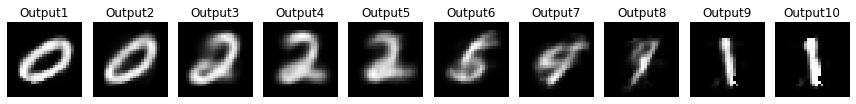

In [131]:
def latent_control():
    model_encoder = VAE_Encoder().to(cfg.DEVICE)
    model_sampler = VAE_Sampler().to(cfg.DEVICE)
    model_decoder = VAE_Decoder().to(cfg.DEVICE)

    model_encoder.load_state_dict(torch.load(cfg.TEST.MODEL_E_PATH, map_location=torch.device(cfg.DEVICE)))
    model_decoder.load_state_dict(torch.load(cfg.TEST.MODEL_D_PATH, map_location=torch.device(cfg.DEVICE)))
    model_encoder.eval()
    model_sampler.eval()
    model_decoder.eval()
    
    summary(model_encoder, (cfg.INPUT_CHANNEL, cfg.INPUT_HEIGHT, cfg.INPUT_WIDTH))
    summary(model_decoder, (cfg.VAE_Z_DIM, ))
    
    plt.figure(figsize=[10, 10])
    
    # split number (show image number)
    show_num = 10

    # latent lower and upper bound
    z1_lower, z1_upper = -2, 2
    z2_lower, z2_upper = -2, 2

    div1 = (z1_upper - z1_lower) / show_num
    div2 = (z2_upper - z2_lower) / show_num
    
    z1s = np.arange(z1_lower, z1_upper + div1, div1)
    z2s = np.arange(z2_lower, z2_upper + div2, div2)
    
    colors = np.array([matplotlib.cm.hsv(i / cfg.CLASS_NUM) for i in range(cfg.CLASS_NUM)])
    
    mb = 512
    
    testset = torchvision.datasets.MNIST(root=cfg.TRAIN.DATA_PATH , train=False, download=True, transform=None)
    test_Xs = testset.data.numpy()
    test_ts = testset.targets
    
    Test_Num = len(test_Xs)
    
    np.random.seed(0)
    
    with torch.no_grad():
        for class_i in range(cfg.CLASS_NUM):
            _test_Xs = test_Xs[test_ts == class_i]

            Test_Num = len(_test_Xs)
            
            z1 = np.ndarray(shape=1)
            z2 = np.ndarray(shape=1)
            
            for i in range(0, Test_Num, mb):
                mb_ind = np.arange(i, min(i + mb, Test_Num))

                # sample X, y
                Xs = torch.tensor(preprocess(_test_Xs[mb_ind], cfg, cfg.INPUT_MODE, hf=False, vf=False, rot=False), dtype=torch.float).to(cfg.DEVICE)           

                # forward
                mu, sigma = model_encoder(Xs)
                z = model_sampler([mu, sigma])
                
                z1 = np.append(z1, z[:, 0])
                z2 = np.append(z2, z[:, 1])

            plt.scatter(z1, z2, c=[colors[class_i]], label=class_i, s=10)
    
    # draw sampling position
    #plt.plot(np.arange(z1_lower, z1_upper, 0.01), np.arange(z2_lower, z2_upper, 0.01), linewidth=3)
    plt.arrow(z1_lower, z2_lower, z1_upper - z1_lower, z2_upper - z2_lower, length_includes_head=True,
          head_width=0.2, head_length=0.2)
    plt.scatter(z1s, z2s, color='black', s=60)
    plt.grid()
    plt.legend()
    
    plt.figure(figsize=[12, 12])
    
    
    with torch.no_grad():
        for i in range(show_num):
            # get latent vector
            z = [[z1s[i], z2s[i]]]
            z = torch.tensor(z, dtype=torch.float).to(cfg.DEVICE)

            # decode latent vector
            ys = model_decoder(z).detach().cpu().numpy()
            ys = (ys * 127.5 + 127.5).astype(np.uint8)
            ys = ys.reshape([-1, cfg.OUTPUT_CHANNEL, cfg.OUTPUT_HEIGHT, cfg.OUTPUT_WIDTH])

            if cfg.OUTPUT_CHANNEL == 1:
                ys = ys[:, 0]
            else:
                ys = ys.transpose(0, 2, 3, 1)

            # show output
            _y = ys[0]
            plt.subplot(1, show_num, i + 1)
            plt.imshow(_y, cmap=cfg.OUTPUT_CMAP)
            plt.axis('off')
            plt.title('Output{}'.format(i + 1))

    plt.tight_layout()
    #plt.savefig('result/vae_latent_change.png')
    plt.show()
    
latent_control()

## Show Latent map

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                   [-1, 64]          50,240
              ReLU-3                   [-1, 64]               0
            Linear-4                   [-1, 32]           2,080
              ReLU-5                   [-1, 32]               0
            Linear-6                    [-1, 2]              66
            Linear-7                    [-1, 2]              66
Total params: 52,452
Trainable params: 52,452
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.20
Estimated Total Size (MB): 0.21
----------------------------------------------------------------
----------------------------------------------------------------
        Layer (type)               Output S

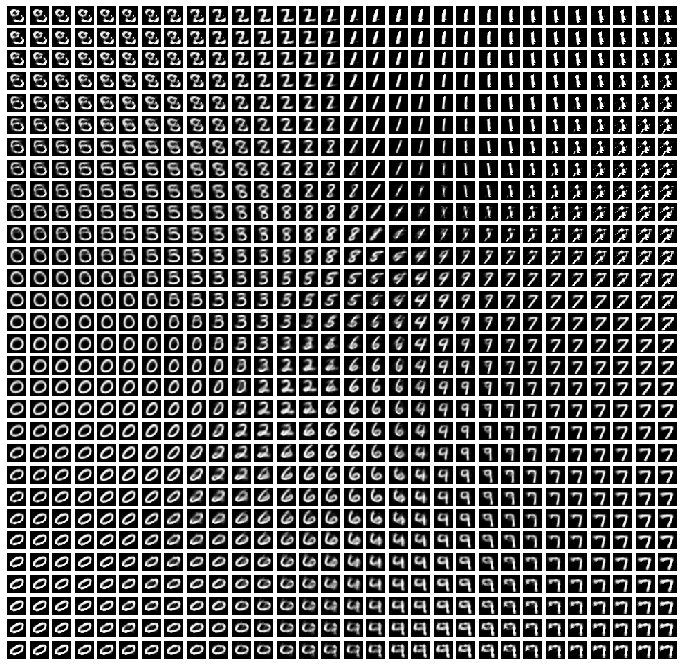

In [112]:
def latent_map():
    model_encoder = VAE_Encoder().to(cfg.DEVICE)
    model_sampler = VAE_Sampler().to(cfg.DEVICE)
    model_decoder = VAE_Decoder().to(cfg.DEVICE)

    model_encoder.load_state_dict(torch.load(cfg.TEST.MODEL_E_PATH, map_location=torch.device(cfg.DEVICE)))
    model_decoder.load_state_dict(torch.load(cfg.TEST.MODEL_D_PATH, map_location=torch.device(cfg.DEVICE)))
    model_encoder.eval()
    model_sampler.eval()
    model_decoder.eval()
    
    summary(model_encoder, (cfg.INPUT_CHANNEL, cfg.INPUT_HEIGHT, cfg.INPUT_WIDTH))
    summary(model_decoder, (cfg.VAE_Z_DIM, ))

    plt.figure(figsize=[12, 12])
    
    # split number (show image number)
    z1_num = 30
    z2_num = 30

    # latent lower and upper bound
    z1_lower, z1_upper = -3, 3
    z2_lower, z2_upper = -3, 3
    
    div1 = (z1_upper - z1_lower) / z1_num
    div2 = (z2_upper - z2_lower) / z2_num
    
    z1s = np.arange(z1_lower, z1_upper + div1, div1)
    z2s = np.arange(z2_lower, z2_upper + div2, div2)
    
    with torch.no_grad():
        for i in range(z2_num):
            z = [[_z1, z2s[i]] for _z1 in z1s]

            z = torch.tensor(z, dtype=torch.float).to(cfg.DEVICE)
                
            # decode latent vector
            ys = model_decoder(z).detach().cpu().numpy()
            ys = (ys * 127.5 + 127.5).astype(np.uint8)
            ys = ys.reshape([-1, cfg.OUTPUT_CHANNEL, cfg.OUTPUT_HEIGHT, cfg.OUTPUT_WIDTH])

            if cfg.OUTPUT_CHANNEL == 1:
                ys = ys[:, 0]
            else:
                ys = ys.transpose(0, 2, 3, 1)

            # show output
            for j in range(z1_num):
                _y = ys[j]
                plt.subplot(z2_num, z1_num, j + (z2_num - 1 - i) * z1_num + 1)
                plt.imshow(_y, cmap=cfg.OUTPUT_CMAP)
                plt.axis('off')
            
    plt.show()
    
latent_map()